# Final Project Submission

Please fill out:
* Student name: Matt LeRoi
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


### Business Understanding

A new movie studio would like input on what sort of films to make. I will present two sets of options, focused on: 1) maximizing the rate of return on their investment and 2) maximizing net profit. The key difference 
the top 10 films by net profit all had budgets over $100M and the top 10 based on rate of return were all $1M and under

### Data Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sqlite3
import statsmodels.formula.api as smf
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

##### Read the budget.csv file and diplay some basics about it.

The budget file is a list of 5782 films and includes the title, release date, production budget, and the domestic and worldwide grosses for each.

In [3]:
budget = pd.read_csv("./data/tn.movie_budgets.csv.gz")
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [4]:
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


##### Format all of the data appropriately for future use and remove irrelevant rows.

In [5]:
# Convert $ columns to numbers
budget.production_budget = pd.to_numeric(budget.production_budget.str.replace('[$,]',''))
budget.domestic_gross = pd.to_numeric(budget.domestic_gross.str.replace('[$,]',''))
budget.worldwide_gross = pd.to_numeric(budget.worldwide_gross.str.replace('[$,]',''))

In [6]:
# Remove rows without worldwide gross data
budget = budget[budget.worldwide_gross != 0]

In [7]:
# Creating columns for release month, release year, profit (based on worldwide gross), 
# and ROI (Return on Investment, as %, i.e.: a ROI of -50% is a loss of half of the 
# production budget, a ROI of 0% is break-even, and a ROI of 75% is a 75% profit)

budget['month']= pd.to_datetime(budget['release_date']).dt.month
budget['year']= pd.to_datetime(budget['release_date']).dt.year
budget['profit'] = budget.worldwide_gross - budget.production_budget
budget['roi'] = 100*budget.profit/budget.production_budget

##### Open the IMDB SQL database and join appropriate tables.

The IMDB SQL database contains various tables with information about films from the years 2010-2019. The details include items like: title, release year, runtime, cast, crew, ratings, etc.

In [8]:
conn = sqlite3.connect("./data/im.db") # Open a connection to IMDB file
cursor = conn.cursor() # Initialize cursor

# SQL query to join movie akas, basics, and ratings tables for further analysis

imdb_query = """SELECT *, movie_akas.movie_id as mv_id
                FROM movie_akas 
                join movie_ratings on movie_akas.movie_id = movie_ratings.movie_id
                join movie_basics on movie_akas.movie_id = movie_basics.movie_id
                ;"""

imdb = pd.read_sql(imdb_query, conn)

# Dropping duplicate movie_id columns (but retaining the mv_id column that I renamed) and redundant "title" column.
imdb.drop(['movie_id','title'],axis = 1, inplace=True)

# Remove redundant rows with same unique identifier (there are redundant rows for the same film being 
# released in different regions)
imdb.drop_duplicates(subset=['mv_id'], inplace=True) 

In [9]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69577 entries, 0 to 261803
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ordering           69577 non-null  int64  
 1   region             58133 non-null  object 
 2   language           5706 non-null   object 
 3   types              24182 non-null  object 
 4   attributes         2015 non-null   object 
 5   is_original_title  69577 non-null  float64
 6   averagerating      69577 non-null  float64
 7   numvotes           69577 non-null  int64  
 8   primary_title      69577 non-null  object 
 9   original_title     69577 non-null  object 
 10  start_year         69577 non-null  int64  
 11  runtime_minutes    62830 non-null  float64
 12  genres             68937 non-null  object 
 13  mv_id              69577 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.0+ MB


In [10]:
imdb.head()

,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,mv_id
0,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
48,1,GB,None,None,None,0.0,7.6,23,Cloud Cuckoo Land,Cloud Cuckoo Land,2012,92.0,Drama,tt0381957
49,10,UA,None,None,None,0.0,6.6,241792,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",tt0401729
83,1,None,None,original,None,1.0,7.0,5,Versailles Rediscovered - The Sun King's Vanis...,Versailles Rediscovered - The Sun King's Vanis...,2019,52.0,Documentary,tt10010134
86,1,IN,None,None,None,0.0,8.3,30,Vinara sodara veera kumara,Vinara sodara veera kumara,2019,NaN,"Drama,Romance",tt10084780


### Data Preparation

The unique identifier from IMDB doesn't correlate to the budget database, so I will
have to use something else to link them. The title alone has a significant number of duplicates, so
I'm using the combination of title and start year to join the databases. Removing the rows
in which both are duplicated (773 of 6191) is deemed an acceptable loss of data.

In [47]:
imdb.drop_duplicates(subset=['primary_title','start_year'], inplace=True) 

KeyError: Index(['primary_title', 'start_year'], dtype='object')

Since the "genres" column has a single entry for each film, often listing several genres, I'm breaking it apart into individual columns to facilitate further analysis. For example, Jurassic World currently lists "Action, Adventure, Sci-Fi" in the "genres" column. The new "Action", "Adventure", and "Sci-Fi" columns will be "True" for Jurassic World and all other genre columns (thriller, romance, reality-TV, etc.) will be "False". In the model, we will see which genres have the greatest effect on profit and ROI, and if certain combinations of genres are more sucessful than others. 

In [12]:
# This will create a list of all of the genres that appear in the IMDB database
genre_list = []
for value in imdb['genres'].str.split(','):
    if value is not None:
        genre_list.extend(value)
genre_list = list(set(genre_list))

# This function will take in a genre name (like "Horror" or "Animation"), create a column in the database for it,
# and populate the column with True or False to show whether that genre applies to each movie.
def add_genre_column (single_genre):
    imdb[single_genre] = imdb['genres'].str.contains(single_genre)

# This loops the genre list and calls the add_genre_column function to add a column for each genre        
for x in genre_list:
    add_genre_column(x)
    
# Rename columns names with dashes in them to avoid future errors
imdb.rename(columns={'Game-Show': 'Game_Show', 'Reality-TV': 'Reality_TV', 'Sci-Fi' : 'Sci_Fi'}, inplace=True)
genre_list = [g.replace('-', '_') for g in genre_list]

In [13]:
# Set index of each dataframe to the movie title and year, then rename for consistency.

budget.set_index(['movie','year'], inplace=True)
budget.index.rename(['title','year'], inplace=True)

imdb.set_index(['primary_title','start_year'], inplace=True)
imdb.index.rename(['title','year'], inplace=True)

##### Time to join the IMDB and budget dataframes.

In [14]:
imdb_budget = pd.concat([imdb, budget], axis=1, join="inner")

In [15]:
# Adding runtime for those I found manually and removing entries for those I couldn't
imdb_budget.loc['Burlesque','runtime_minutes']=119
imdb_budget.drop(imdb_budget[imdb_budget['original_title'].str.contains('The Promise')].index, inplace=True)

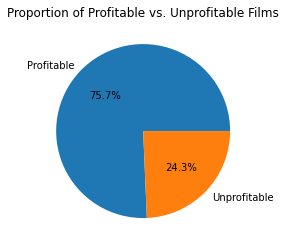

In [54]:
plt.pie([len(imdb_budget[imdb_budget.profit > 0]),len(imdb_budget[imdb_budget.profit < 0])], labels=['Profitable', 'Unprofitable'],autopct='%1.1f%%')
plt.title('Proportion of Profitable vs. Unprofitable Films');

In [16]:
# This function formats the dollar values in the plots to show in millions of dollars for readability.
# I adapted it for my purposes, from here: https://matplotlib.org/3.4.3/gallery/ticks_and_spines/custom_ticker1.html

def millions(x, pos):
    return '${:,.0f}M'.format(x*1e-6)

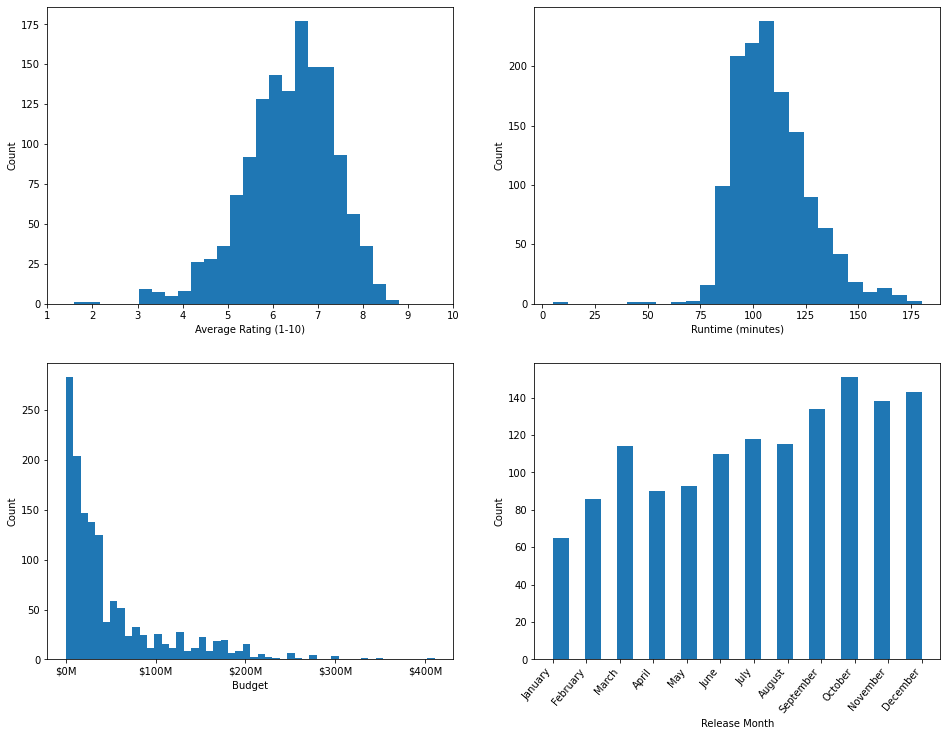

In [17]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].hist(imdb_budget.averagerating, bins=25)
axs[0, 0].set_xlabel('Average Rating (1-10)')
axs[0, 0].set_xticks(range(1, 11, 1))
axs[0, 1].hist(imdb_budget.runtime_minutes, bins=25)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].hist(imdb_budget.production_budget, bins=50)
axs[1, 0].set_xlabel('Budget')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].hist(imdb_budget.month, bins=23)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='Count')
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

''

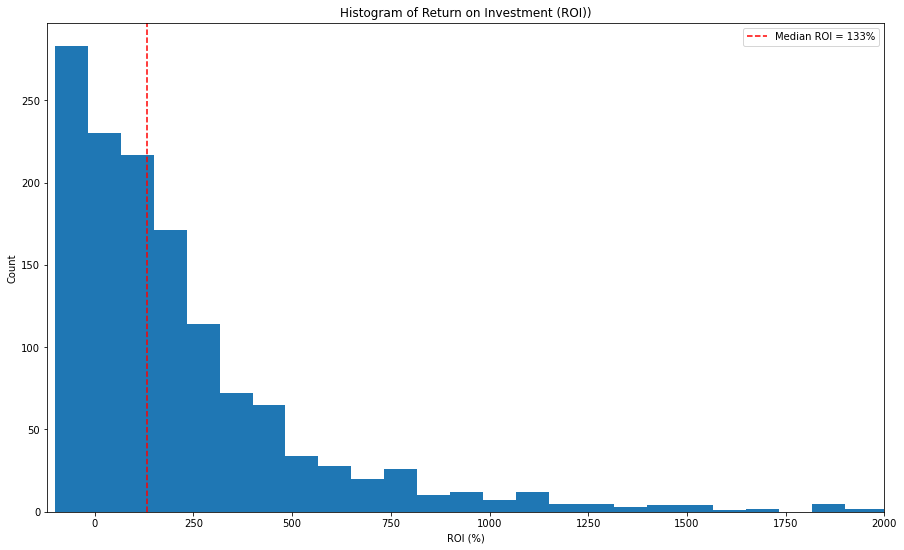

In [18]:
fig, ax = plt.subplots(figsize=(15,9))
plt.hist(imdb_budget.roi, bins=500)

ax.set_title('Histogram of Return on Investment (ROI))')
ax.set_xlabel('ROI (%)')
ax.set_ylabel('Count')
ax.set_xlim([-120, 2000]) # There are outliers at 10,000% and 40,000% that make the whole chart hard to read at full scale.
plt.axvline(x=imdb_budget.roi.median(), color='r', linestyle='--', label = 'Median ROI = 133%') # Used median rather than mean due to the outliers.
plt.legend()
;

''

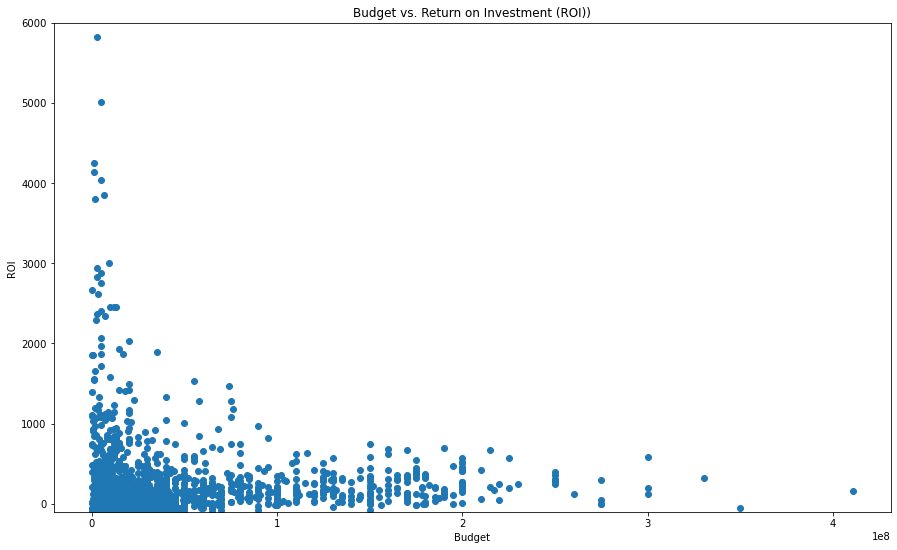

In [19]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(imdb_budget.production_budget,imdb_budget.roi)

ax.set_title('Budget vs. Return on Investment (ROI))')
ax.set_xlabel("Budget")
ax.set_ylabel("ROI")
ax.set_ylim([-100, 6000]) # Limited again for visibility.
;

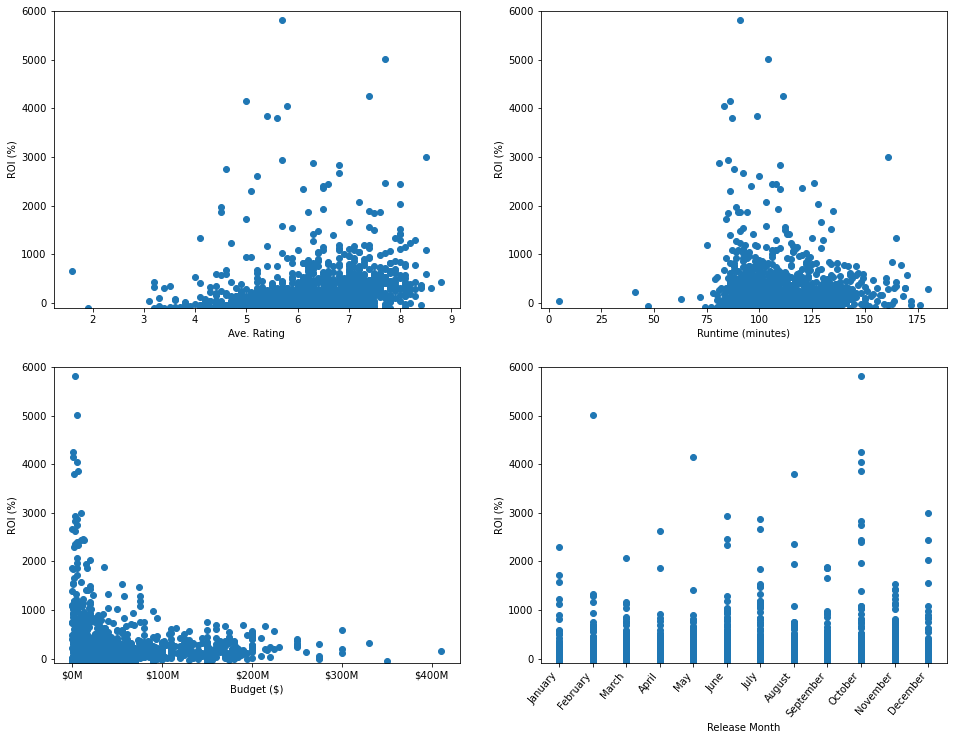

In [20]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].scatter(imdb_budget.averagerating,imdb_budget.roi)
axs[0, 0].set_xlabel('Ave. Rating')
axs[0, 1].scatter(imdb_budget.runtime_minutes,imdb_budget.roi)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].scatter(imdb_budget.production_budget,imdb_budget.roi)
axs[1, 0].set_xlabel('Budget ($)')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].scatter(imdb_budget.month,imdb_budget.roi)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='ROI (%)')
    ax.set(ylim=[-100,6000]) # Limited again for visibility.
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

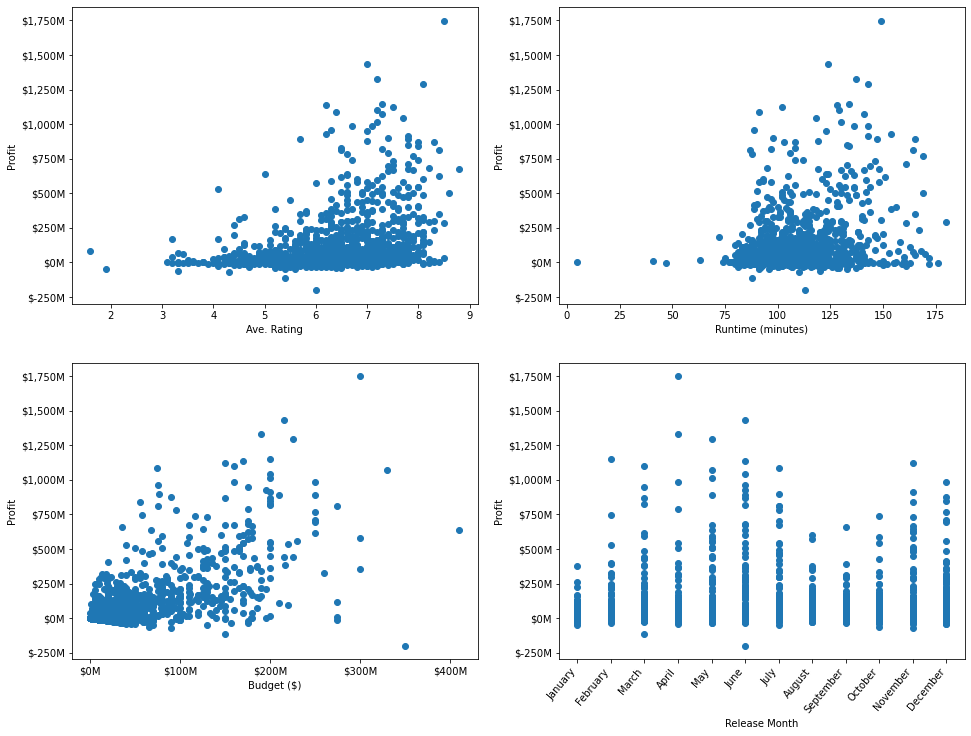

In [21]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].scatter(imdb_budget.averagerating,imdb_budget.profit)
axs[0, 0].set_xlabel('Ave. Rating')
axs[0, 1].scatter(imdb_budget.runtime_minutes,imdb_budget.profit)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].scatter(imdb_budget.production_budget,imdb_budget.profit)
axs[1, 0].set_xlabel('Budget ($)')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].scatter(imdb_budget.month,imdb_budget.profit)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='Profit')
    ax.yaxis.set_major_formatter(millions)
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

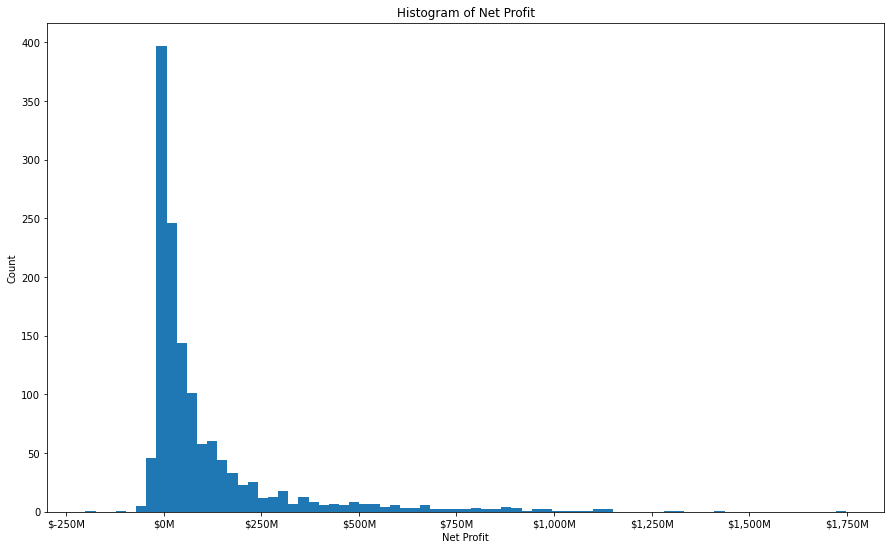

In [22]:
fig, ax = plt.subplots(figsize=(15,9))
plt.hist(imdb_budget.profit, bins=75)

ax.set_title('Histogram of Net Profit')
ax.set_xlabel('Net Profit')
ax.set_ylabel('Count')
ax.xaxis.set_major_formatter(millions);

### Modeling

This will create the model for return on investment vs. genre, runtime, rating, and budget.

In [23]:
# Creating a new genre list that includes only genres that appear in the combined imdb/budget dataframe.
imdb_budget_genre_list = []
for value in imdb_budget['genres'].str.split(','):
    if value is not None:
        imdb_budget_genre_list.extend(value)
imdb_budget_genre_list = list(set(imdb_budget_genre_list))
imdb_budget_genre_list = [g.replace('-', '_') for g in imdb_budget_genre_list]

In [24]:
# Using the imdb_budget_genre_list to populate the formula for the model, with ROI as the dependent variable.
genre_string_for_formula = ') + C('.join([str(g) for g in imdb_budget_genre_list])
formula = 'roi ~ C('+genre_string_for_formula+')'+ '+runtime_minutes + averagerating + production_budget'
lm = smf.ols(formula, imdb_budget).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.402
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           6.35e-08
Time:                        11:19:41   Log-Likelihood:                -11570.
No. Observations:                1357   AIC:                         2.319e+04
Df Residuals:                    1332   BIC:                         2.332e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -50.3493    334.421     -0.151      0.880    -706.399     605.701
C(Romance)[T.True]        46.2197    116.807      0.396      0.692    -182.927     275.366
C(Comedy)[T.True]        -35.2039    104.576     -0.337      0.736    -240.355     169.947
C(Biography)[T.True]      54.1250    132.556      0.408      0.683    -205.916     314.166
C(Adventure)[T.True]      30.7994    116.438      0.265      0.791    -197.622     259.221
C(Western)[T.True]      -168.6119    418.615     -0.403      0.687    -989.829     652.605
C(Family)[T.True]        -46.2362    150.169     -0.308      0.758    -340.830     248.357
C(History)[T.True]       -76.5551    216.948     -0.353      0.724    -502.152     349.042
C(Fantasy)[T.True]       -88.0263    138.111     -0.637      0.524    -358.964     182.912
C(Horror)[T.True]        525.5296    135.040      3.892      0.000     260.615     790.444
C(Thriller)[T.True]      191.4529    113.190      1.691      0.091     -30.597     413.503
C(Crime)[T.True]        -209.1418    107.304     -1.949      0.051    -419.645       1.361
C(Sport)[T.True]        -123.1448    234.148     -0.526      0.599    -582.483     336.193
C(Documentary)[T.True]  -169.6243    277.827     -0.611      0.542    -714.650     375.401
C(War)[T.True]          -169.9225    310.267     -0.548      0.584    -778.587     438.742
C(Sci_Fi)[T.True]        -91.7057    137.538     -0.667      0.505    -361.521     178.110
C(Mystery)[T.True]       433.5588    135.536      3.199      0.001     167.672     699.445
C(Musical)[T.True]        24.4147    538.858      0.045      0.964   -1032.689    1081.518
C(Music)[T.True]          44.3076    193.917      0.228      0.819    -336.108     424.723
C(Action)[T.True]        -67.4056     98.175     -0.687      0.492    -260.000     125.189
C(Animation)[T.True]     -23.3875    166.575     -0.140      0.888    -350.165     303.390
C(Drama)[T.True]        -137.6685    100.474     -1.370      0.171    -334.773      59.436
runtime_minutes           -1.4870      2.497     -0.595      0.552      -6.386       3.412
averagerating             87.3151     40.429      2.160      0.031       8.003     166.627
production_budget       -5.99e-07   9.12e-07     -0.657      0.512   -2.39e-06    1.19e-06
==============================================================================
Omnibus:                     3451.613   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42603481.639
Skew:                          26.795   Prob(JB):                         0.00
Kurtosis:                     869.381   Cond. No.                     1.22e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

The statistically significant factors shown are horror, mystery, and average rating with an alpha of 0.05. Thriller and crime join the list if we use alpha of 0.10. Given the wide range results in ROI in this data set

In [25]:
# Using the same code again to populate the formula for the profit model (with ROI changed to profit).
genre_string_for_formula = ') + C('.join([str(g) for g in imdb_budget_genre_list])
formula = 'profit ~ C('+genre_string_for_formula+')'+ '+runtime_minutes + averagerating + production_budget'
lm = smf.ols(formula, imdb_budget).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     56.11
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.44e-182
Time:                        11:19:41   Log-Likelihood:                -27383.
No. Observations:                1357   AIC:                         5.482e+04
Df Residuals:                    1332   BIC:                         5.495e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.377e+08   3.84e+07     -8.784      0.000   -4.13e+08   -2.62e+08
C(Romance)[T.True]      2.493e+06   1.34e+07      0.186      0.853   -2.38e+07    2.88e+07
C(Comedy)[T.True]       8.582e+06    1.2e+07      0.714      0.475    -1.5e+07    3.22e+07
C(Biography)[T.True]   -1.192e+07   1.52e+07     -0.782      0.434   -4.18e+07     1.8e+07
C(Adventure)[T.True]    7.362e+06   1.34e+07      0.550      0.582   -1.89e+07    3.36e+07
C(Western)[T.True]     -8.436e+07   4.81e+07     -1.753      0.080   -1.79e+08       1e+07
C(Family)[T.True]      -9.879e+06   1.73e+07     -0.572      0.567   -4.37e+07     2.4e+07
C(History)[T.True]     -2.728e+07   2.49e+07     -1.094      0.274   -7.62e+07    2.16e+07
C(Fantasy)[T.True]     -1.356e+07   1.59e+07     -0.854      0.393   -4.47e+07    1.76e+07
C(Horror)[T.True]       3.336e+07   1.55e+07      2.149      0.032    2.91e+06    6.38e+07
C(Thriller)[T.True]     2.662e+07    1.3e+07      2.046      0.041    1.09e+06    5.21e+07
C(Crime)[T.True]       -2.001e+07   1.23e+07     -1.622      0.105   -4.42e+07    4.19e+06
C(Sport)[T.True]       -3.812e+07   2.69e+07     -1.416      0.157   -9.09e+07    1.47e+07
C(Documentary)[T.True] -1.906e+07   3.19e+07     -0.597      0.551   -8.17e+07    4.36e+07
C(War)[T.True]          -2.21e+07   3.57e+07     -0.620      0.536   -9.21e+07    4.79e+07
C(Sci_Fi)[T.True]       4.912e+07   1.58e+07      3.107      0.002    1.81e+07    8.01e+07
C(Mystery)[T.True]     -1.001e+06   1.56e+07     -0.064      0.949   -3.16e+07    2.96e+07
C(Musical)[T.True]      1.048e+08   6.19e+07      1.691      0.091   -1.68e+07    2.26e+08
C(Music)[T.True]        3.068e+07   2.23e+07      1.376      0.169   -1.31e+07    7.44e+07
C(Action)[T.True]      -1.656e+07   1.13e+07     -1.467      0.143   -3.87e+07    5.58e+06
C(Animation)[T.True]    6.961e+07   1.91e+07      3.635      0.000     3.2e+07    1.07e+08
C(Drama)[T.True]       -4.066e+07   1.16e+07     -3.521      0.000   -6.33e+07    -1.8e+07
runtime_minutes          7.42e+05   2.87e+05      2.585      0.010    1.79e+05    1.31e+06
averagerating           4.448e+07   4.65e+06      9.570      0.000    3.54e+07    5.36e+07
production_budget          1.8490      0.105     17.630      0.000       1.643       2.055
==============================================================================
Omnibus:                      610.934   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8043.057
Skew:                           1.734   Prob(JB):                         0.00
Kurtosis:                      14.412   Cond. No.                     1.22e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix

In [27]:
table = lm.summary2().tables[1]
table.sort_values('P>|t|')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
production_budget,1.849026e+00,1.048786e-01,17.630155,1.086997e-62,1.643281e+00,2.054771e+00
averagerating,4.448008e+07,4.647689e+06,9.570364,4.964002e-21,3.536249e+07,5.359767e+07
Intercept,-3.376956e+08,3.844443e+07,-8.783992,4.758833e-18,-4.131138e+08,-2.622774e+08
C(Animation)[T.True],6.961154e+07,1.914913e+07,3.635233,2.883083e-04,3.204580e+07,1.071773e+08
C(Drama)[T.True],-4.066358e+07,1.155027e+07,-3.520574,4.451393e-04,-6.332229e+07,-1.800488e+07
C(Sci_Fi)[T.True],4.911739e+07,1.581116e+07,3.106502,1.933146e-03,1.809991e+07,8.013487e+07
runtime_minutes,7.420254e+05,2.870728e+05,2.584799,9.849119e-03,1.788613e+05,1.305189e+06
C(Horror)[T.True],3.336445e+07,1.552394e+07,2.149225,3.179627e-02,2.910408e+06,6.381849e+07
C(Thriller)[T.True],2.662102e+07,1.301210e+07,2.045866,4.096563e-02,1.094567e+06,5.214747e+07
C(Western)[T.True],-8.436380e+07,4.812320e+07,-1.753080,7.981838e-02,-1.787693e+08,1.004172e+07


The statistically significant factors are: production budget, average rating, runtime, and the genres horror, sci-fi, drama, animation, and thriller. Of those, the following have positive effects on profit: production budget, rating, animation, sci-fi, runtime, horror, and thriller. Dramas are negatively correlated with profit.

In [29]:
# Create table of genres vs mean ROI, profit, and worldwide gross

genre_means = pd.DataFrame([(g, imdb_budget['production_budget'][imdb_budget[g]==True].mean(),
                             imdb_budget['roi'][imdb_budget[g]==True].mean(), 
                             imdb_budget['profit'][imdb_budget[g]==True].mean(), 
                             imdb_budget['worldwide_gross'][imdb_budget[g]==True].mean()) 
                            for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])

# Add a line for the overall averages for comparison
overall = {'genre': 'Overall', 
          'budget' : imdb_budget['production_budget'].mean(),
          'mean_roi': imdb_budget['roi'].mean(), 
          'mean_profit': imdb_budget['profit'].mean(), 
          'mean_ww_gross': imdb_budget['worldwide_gross'].mean()                               }
genre_means = genre_means.append(overall, ignore_index=True)

# Create lists of top 3 genres for ROI and profit, plus overall
top_roi = genre_means.sort_values('mean_roi', ascending=False).head(3).append(overall, ignore_index=True)
top_profit = genre_means.sort_values('mean_profit', ascending=False).head(3).append(overall, ignore_index=True)

In [30]:
genre_means.sort_values('mean_roi', ascending=False)

,genre,budget,mean_roi,mean_profit,mean_ww_gross
8,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
15,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
9,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
21,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08
14,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
19,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
0,Romance,2.319897e+07,266.997046,4.729594e+07,7.049490e+07
17,Music,2.167212e+07,260.835228,8.068378e+07,1.023559e+08
2,Biography,2.645326e+07,249.716421,5.680710e+07,8.326035e+07
20,Drama,2.831032e+07,239.786746,5.072263e+07,7.903295e+07


In [31]:
top_profit

,genre,budget,mean_roi,mean_profit,mean_ww_gross
0,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
1,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
2,Adventure,1.092426e+08,216.977629,2.522447e+08,3.614874e+08
3,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


In [32]:
top_roi

,genre,budget,mean_roi,mean_profit,mean_ww_gross
0,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
1,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
2,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
3,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


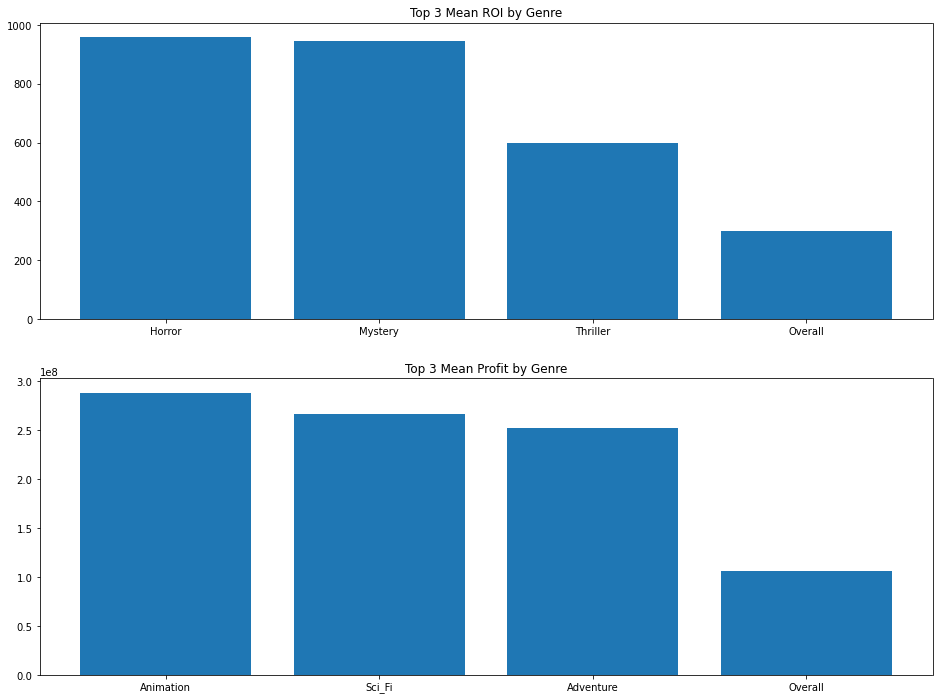

In [33]:
x= top_roi['genre']
y=top_roi['mean_roi']
fig, axs = plt.subplots(2, figsize=(16,12))
axs[0].bar(top_roi['genre'], top_roi['mean_roi'])
axs[0].set_title('Top 3 Mean ROI by Genre')
axs[1].bar(top_profit['genre'], top_profit['mean_profit'])
axs[1].set_title('Top 3 Mean Profit by Genre');

In [35]:
def genre_combos(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
    
    # also check to see if rating, budget, or runtime have a significant affect on roi for this particular genre
    formula = 'roi ~ runtime_minutes + averagerating + production_budget'
    lm = smf.ols(formula, all_main_genre).fit()
    this_genre_summary = lm.summary()
    
    return main_genre_means.sort_values('mean_roi', ascending=False), this_genre_summary

horror_means, horror_results = genre_combos('Horror')
horror_means
# horror_results

,genre,budget,mean_roi,mean_profit,mean_ww_gross
15,Mystery,1.175361e+07,1829.866821,7.215167e+07,8.390528e+07
9,Thriller,1.240040e+07,1696.796697,7.922419e+07,9.162459e+07
8,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
20,Drama,1.817244e+07,455.375358,3.839690e+07,5.656934e+07
14,Sci_Fi,3.316667e+07,393.294086,7.627897e+07,1.094456e+08
10,Crime,1.308000e+07,349.261721,2.981656e+07,4.289656e+07
18,Action,4.421818e+07,210.003109,7.930668e+07,1.235249e+08
3,Adventure,4.561250e+07,158.286001,7.824883e+07,1.238613e+08
7,Fantasy,3.890238e+07,129.548461,3.352697e+07,7.242935e+07
1,Comedy,2.714000e+07,109.675351,1.679593e+07,4.393593e+07


In [36]:
mystery_means, mystery_results = genre_combos('Mystery')
mystery_means
# mystery_results

,genre,budget,mean_roi,mean_profit,mean_ww_gross
8,Horror,1.175361e+07,1829.866821,7.215167e+07,8.390528e+07
9,Thriller,2.118554e+07,1791.001058,9.540731e+07,1.165928e+08
15,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
1,Comedy,2.154000e+07,327.115100,1.156889e+08,1.372289e+08
3,Adventure,8.500000e+07,313.162073,1.480358e+08,2.330358e+08
20,Drama,2.651430e+07,283.800390,4.057901e+07,6.709331e+07
14,Sci_Fi,4.114286e+07,248.287380,8.599010e+07,1.271330e+08
18,Action,6.107692e+07,190.605430,9.660330e+07,1.576802e+08
10,Crime,3.246800e+07,160.496433,4.641682e+07,7.888482e+07
13,War,6.800000e+06,135.857985,9.238343e+06,1.603834e+07


In [37]:
thriller_means, thrill_results = genre_combos('Thriller')
thriller_means
# thrill_results

,genre,budget,mean_roi,mean_profit,mean_ww_gross
15,Mystery,2.118554e+07,1791.001058,9.540731e+07,1.165928e+08
8,Horror,1.240040e+07,1696.796697,7.922419e+07,9.162459e+07
9,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
0,Romance,3.864000e+07,484.912975,2.033518e+08,2.419918e+08
14,Sci_Fi,4.160476e+07,409.345288,1.486035e+08,1.902082e+08
2,Biography,3.422857e+07,291.789964,7.707519e+07,1.113038e+08
20,Drama,2.601707e+07,262.859494,5.343600e+07,7.945307e+07
7,Fantasy,3.350000e+07,228.625983,3.591047e+07,6.941047e+07
6,History,3.266667e+07,178.962101,7.842948e+07,1.110962e+08
18,Action,6.694231e+07,176.674565,1.438673e+08,2.108096e+08


In [39]:
def genre_combos_profit(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
    
    # also run analysis on rating vs genre and budget vs genre? and runtime?
    formula = 'profit ~ runtime_minutes + averagerating'
    lm = smf.ols(formula, all_main_genre).fit()
    this_genre_summary = lm.summary()
    
    return main_genre_means.sort_values('mean_profit', ascending=False), this_genre_summary

animation_means, anim_results = genre_combos_profit('Animation')
print(animation_means)
anim_results

        genre        budget    mean_roi   mean_profit  mean_ww_gross
18     Action  1.142500e+08  248.862486  3.069505e+08   4.212005e+08
3   Adventure  1.045632e+08  276.030407  2.962842e+08   4.008474e+08
1      Comedy  9.753205e+07  298.556991  2.929458e+08   3.904779e+08
19  Animation  1.001939e+08  278.690125  2.885616e+08   3.887555e+08
5      Family  6.405000e+07  237.259701  1.794857e+08   2.435357e+08
20      Drama  8.000000e+06  -28.672900 -2.293832e+06   5.706168e+06


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     13.25
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           8.42e-06
Time:                        12:10:13   Log-Likelihood:                -2033.1
No. Observations:                  98   AIC:                             4072.
Df Residuals:                      95   BIC:                             4080.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.07e+09    3.1e+08     -3.446      0.001   -1.69e+09   -4.54e+08
runtime_minutes  8.637e+06   3.58e+06      2.412      0.018    1.53e+06    1.57e+07
averagerating    8.201e+07   2.64e+07      3.105      0.003    2.96e+07    1.34e+08
==============================================================================
Omnibus:                       24.235   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.090
Skew:                           1.208   Prob(JB):                     6.53e-08
Kurtosis:                       4.507   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
scifi_means, scifi_results = genre_combos_profit('Sci_Fi')
print(scifi_means)
scifi_results

        genre        budget    mean_roi   mean_profit  mean_ww_gross
3   Adventure  1.660386e+08  274.248053  4.668479e+08   6.328865e+08
18     Action  1.298583e+08  282.462587  3.527055e+08   4.825638e+08
14     Sci_Fi  1.002206e+08  284.919637  2.670834e+08   3.673040e+08
9    Thriller  4.160476e+07  409.345288  1.486035e+08   1.902082e+08
20      Drama  5.538190e+07  324.308572  1.353754e+08   1.907573e+08
15    Mystery  4.114286e+07  248.287380  8.599010e+07   1.271330e+08
8      Horror  3.316667e+07  393.294086  7.627897e+07   1.094456e+08
0     Romance  3.356250e+07  259.182459  5.141085e+07   8.497335e+07
5      Family  1.300000e+07  224.419577  2.917454e+07   4.217454e+07
1      Comedy  3.080000e+07   96.221035  2.771306e+07   5.851306e+07
10      Crime  5.425000e+07   10.715058  2.597941e+07   8.022941e+07
7     Fantasy  3.200000e+06  471.423750  1.508556e+07   1.828556e+07


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     40.32
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           3.62e-14
Time:                        12:10:15   Log-Likelihood:                -2604.2
No. Observations:                 125   AIC:                             5214.
Df Residuals:                     122   BIC:                             5223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.287e+09   1.85e+08     -6.948      0.000   -1.65e+09   -9.21e+08
runtime_minutes   8.95e+06   1.44e+06      6.197      0.000    6.09e+06    1.18e+07
averagerating    7.867e+07   2.91e+07      2.703      0.008    2.11e+07    1.36e+08
==============================================================================
Omnibus:                       41.604   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.019
Skew:                           1.351   Prob(JB):                     3.84e-21
Kurtosis:                       6.280   Cond. No.                         895.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
adventure_means, adv_results = genre_combos_profit('Adventure')
print(adventure_means)
adv_results

        genre        budget    mean_roi   mean_profit  mean_ww_gross
14     Sci_Fi  1.660386e+08  274.248053  4.668479e+08   6.328865e+08
19  Animation  1.045632e+08  276.030407  2.962842e+08   4.008474e+08
18     Action  1.305135e+08  203.741637  2.903387e+08   4.208522e+08
7     Fantasy  1.408236e+08  195.445884  2.627528e+08   4.035764e+08
3   Adventure  1.092426e+08  216.977629  2.522447e+08   3.614874e+08
1      Comedy  8.533360e+07  261.651254  2.358523e+08   3.211859e+08
9    Thriller  1.025000e+08  164.637690  2.000400e+08   3.025400e+08
5      Family  1.048512e+08  109.303806  1.631259e+08   2.679771e+08
15    Mystery  8.500000e+07  313.162073  1.480358e+08   2.330358e+08
20      Drama  6.699167e+07  183.135781  1.094944e+08   1.764860e+08
2   Biography  4.762500e+07  231.149839  8.701905e+07   1.346441e+08
10      Crime  4.785714e+07  149.648564  7.860231e+07   1.264595e+08
8      Horror  4.561250e+07  158.286001  7.824883e+07   1.238613e+08
4     Western  1.011250e+08  155.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     62.05
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.14e-23
Time:                        12:10:16   Log-Likelihood:                -7066.8
No. Observations:                 340   AIC:                         1.414e+04
Df Residuals:                     337   BIC:                         1.415e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.861e+08   1.12e+08     -8.775      0.000   -1.21e+09   -7.65e+08
runtime_minutes  3.642e+06   8.03e+05      4.536      0.000    2.06e+06    5.22e+06
averagerating    1.284e+08   1.61e+07      7.958      0.000    9.66e+07     1.6e+08
==============================================================================
Omnibus:                       84.282   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.528
Skew:                           1.283   Prob(JB):                     2.08e-38
Kurtosis:                       5.380   Cond. No.                         912.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

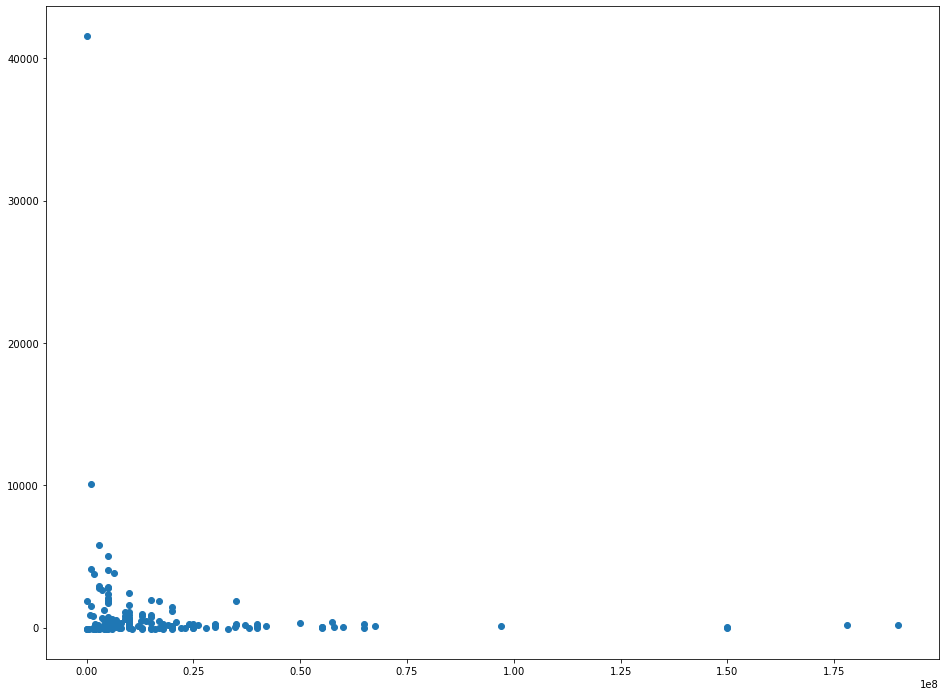

In [42]:
all_horror = imdb_budget[imdb_budget['Horror']==True]
fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(all_horror.production_budget, all_horror.roi)
ax.set_title('');

### Evaluation

### Deployment

In [ ]:
# budget.drop_duplicates(subset=['movie','year'],, keep=False inplace=True)
# budget[budget.movie.duplicated(keep=False)].sort_values('movie')

In [ ]:
# There is one duplicate movie title. I will 

# budget.drop_duplicates(subset=['movie','year'], inplace=True)
# budget

In [ ]:
# imdb[imdb['primary_title'].str.contains( 'The Promise')]
# # budget.reset_index(inplace=True)
# # budget[budget['title'].str.contains( 'The Promise')]

In [ ]:
# budget[budget.index.duplicated(keep=False)].sort_values('movie').head(50)

In [ ]:
# imdb.reset_index(inplace=True)
# imdb.drop_duplicates(subset=['title','year'], keep=False)


# budget[budget.index.duplicated(keep=False)]

In [ ]:
# gross[gross.index.duplicated(keep=False)].sort_values('title').head(50)
# gross.drop_duplicates(subset='title', inplace=True)

In [ ]:
# gross=pd.read_csv("./data/bom.movie_gross.csv.gz")
# gross.info()

In [ ]:
# gross.head()

In [ ]:
# # Convert foreign gross to a number
# gross['foreign_gross'] = pd.to_numeric(gross.foreign_gross.str.replace('[,]',''))

# #Foreign gross over $1 billion is listed in millions (verified by comparing this database to the budget database)
# gross.loc[gross[gross['title']=='The Fate of the Furious'].index,'foreign_gross'] = 1010*1000000
# gross.loc[gross[gross['title']=='Jurassic World'].index,'foreign_gross'] = 1019.4*1000000
# gross.loc[gross[gross['title']=='Star Wars: The Force Awakens'].index,'foreign_gross'] = 1131.6*1000000
# gross.loc[gross[gross['title']=='Furious 7'].index,'foreign_gross'] = 1163*1000000
# gross.loc[gross[gross['title']=='Avengers: Infinity War'].index,'foreign_gross'] = 1369.5*1000000
# gross.fillna(0, inplace=True)

# gross['worldwide_gross'] = gross.domestic_gross + gross.foreign_gross
# gross.set_index(['title','year'], inplace=True)
# imdb_gross = pd.concat([imdb, gross], axis=1, join="inner")

In [ ]:
# budget.sort_values('roi').tail(10)

In [ ]:
# imdb_budget.sort_values('year').head(10)

In [ ]:
# imdb.reset_index(inplace=True)
# imdb.loc[imdb['title'].str.contains('Super Size')]
# imdb.value_counts('year')


In [ ]:
# X=imdb_budget[['production_budget']]
# y=imdb_budget.roi

# # Create an OLS model
# model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [ ]:
# # Get model results
# results = model.fit()
# # Display results summary
# results.summary()

In [ ]:
# # Plot the model fit (scatter plot and regression line)
# sns.regplot(x="production_budget",y="roi",data=imdb_budget);

In [ ]:
# X=imdb_budget[['production_budget','averagerating', 'runtime_minutes']]
# y=imdb_budget.roi

# # Create an OLS model
# model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [ ]:
# # Get model results
# results = model.fit()
# # Display results summary
# results.summary()

In [ ]:
# table = sm.stats.anova_lm(lm, typ=2)
# table.sort_values('PR(>F)', inplace=True, ascending=True)
# print(table)